# RHS comparison

In [2]:
import sys
from itertools import combinations
from math import sin
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from tqdm import tqdm

sys.path.append("../code/")

import xgi
from hypersync_draw import *
from hypersync_generate import *
from hypersync_identify import *
from hypersync_integrate import *

sb.set_theme(style="ticks", context="notebook")

## Definitions

In [3]:
import networkx as nx

In [22]:
r1 = 2
N = 10
G = nx.circulant_graph(N, range(1, r1 + 1)) # ring 

S = xgi.flag_complex_d2(G)

(<Axes: >, <matplotlib.collections.PathCollection at 0x296fa87f0>)

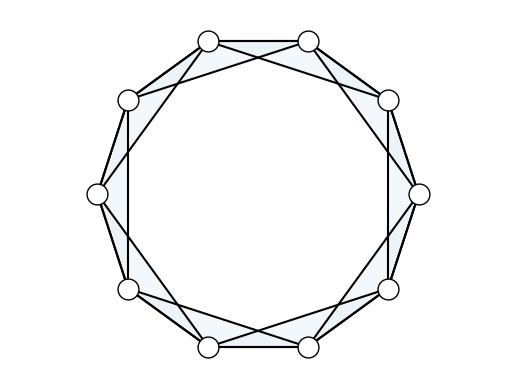

In [23]:
pos = xgi.circular_layout(S)
xgi.draw(S, pos)

In [89]:
from numba import jit
#@jit(nopython=True)
def rhs_oneloop_SC_nb(t, theta, omega, k1, k2, r1, r2):
    """
    RHS

    Parameters
    ----------
    sigma : float
        Triplet coupling strength
    K1, K2 : int
        Pairwise and triplet nearest neighbour ranges
    """

    N = len(theta)

    pairwise = np.zeros(N)
    triplets = np.zeros(N)

    # triadic coupling
    idx_2 = list(range(-r2, 0)) + list(range(1, r2 + 1))
    idx_1 = range(-r1, r1 + 1)

    for ii in range(N):
        for jj in idx_1:  # pairwise
            jjj = (ii + jj) % N
            pairwise[ii] += sin(theta[jjj] - theta[ii])

        for jj in idx_2:  # triplet
            for kk in idx_2:
                if (jj < kk) and (kk - jj) <= r2: # because coupling function is symmetric in j and k
                    jjj = (ii + jj) % N
                    kkk = (ii + kk) % N
                    # x2 to count triangles in both directions
                    triplets[ii] += 2 * sin(theta[kkk] + theta[jjj] - 2 * theta[ii])

    return (k1 / r1) * pairwise + k2 / (r2 * (2 * r2 - 1)) * triplets

In [67]:
def rhs_max(t, psi, omega, k1, k2, r1, r2, adj1, triangles):
    """
    RHS
    
    Parameters
    ----------
    k1, k2 : floats
        Pairwise and triplet coupling strengths
    r1, r2 : int
        Pairwise and triplet nearest neighbour ranges
    adj1 : ndarray, shape (N, N)
        Adjacency matrix of order 1
    triangles: list of sets
        List of unique triangles
    
    """
        
    N = len(psi)
    sin_psi = np.sin(psi)
    cos_psi = np.cos(psi)

    pairwise = adj1.dot(sin_psi) * cos_psi - adj1.dot(cos_psi) * sin_psi

    triplet = np.zeros(N)
    
    #print(len(triangles))
    for i, j, k in triangles:
        #print(i,j,k)
        # sin(2 oj - ok - oi)
        oi = psi[i]
        oj = psi[j]
        ok = psi[k]
        triplet[i] += 2 * sin(oj + ok - 2 * oi)
        triplet[j] += 2 * sin(oi + ok - 2 * oj)
        triplet[k] += 2 * sin(oj + oi - 2 * ok)

    g1 = r1
    g2 = r2 * (2 * r2 - 1)

    return omega + (k1 / g1) * pairwise + (k2 / g2) * triplet



## Generate structure 

In [69]:
# structural parameters
N = 1000

r1 = 2
r2 = 2

G = nx.circulant_graph(N, range(1, r1 + 1)) # ring 
H = xgi.flag_complex_d2(G)

In [70]:
# may be used in the simulation function
links = H.edges.filterby("size", 2).members()
triangles = H.edges.filterby("size", 3).members()
adj1 = xgi.adjacency_matrix(H, order=1, sparse=False)

### Contributions are the same

In [71]:
# dynamical parameters
omega = 0 #1 * np.ones(N)  # np.random.normal(size=N) #1 * np.ones(N)
t = 0

In [72]:
k1 = 1  #pairwise coupling strength
k2 = 1  # triplet coupling strength
sigma0 = k1
sigma = k2

In [73]:
psi = generate_state(N=N, kind="random", noise=0) # random state

In [74]:
y_max = rhs_max(t, psi, omega, k1, k2, r1, r2, adj1, triangles)

In [75]:
y_loop = rhs_oneloop_SC_nb(t, psi, omega, k1, k2, r1, r2)

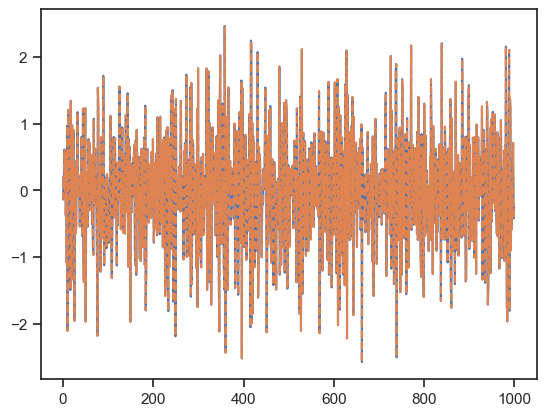

In [76]:
plt.plot(y_max)
plt.plot(y_loop, "--")

In [77]:
np.allclose(y_max, y_loop)

True

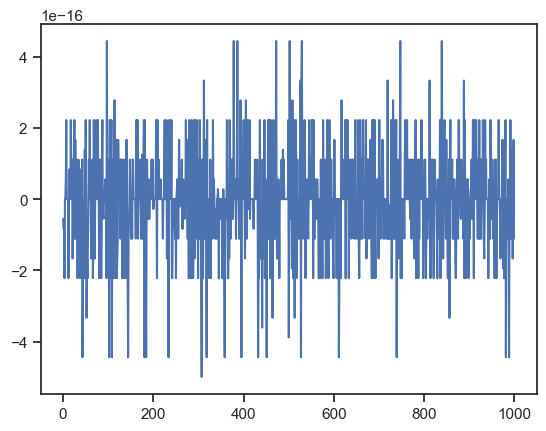

In [78]:
plt.plot(y_max - y_loop)

## Speed

In [81]:
%timeit y_max = rhs_max(t, psi, omega, k1, k2, r1, r2, adj1, triangles)

122 ms ± 33.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
%timeit y_loop = rhs_oneloop_SC_nb(t, psi, omega, k1, k2, r1, r2)

8.51 ms ± 3.04 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Summary for 83 nodes: 

- loop over triangles, no numba: 87.2 µs
- loop over triangles, numba: nopython impossible, 110 µs
- loop over nodes, no numba: 266 µs
- loop over nodes, numba: 7.4 µs

With numba, best is plain loop over nodes, by a factor 10.  
Without numba, best is loop over triangles, by factor 4. 

For larger network, 1000 nodes, plain loop numba is 1000 times faster than triangle loop. Even without numba, plain loop is still 20 times faster.

## is directed or undirected faster with numba loop?

In [84]:
@jit(nopython=True)
def rhs_oneloop_nb(t, theta, omega, k1, k2, r1, r2):
    """
    RHS

    Parameters
    ----------
    sigma : float
        Triplet coupling strength
    K1, K2 : int
        Pairwise and triplet nearest neighbour ranges
    """

    N = len(theta)

    pairwise = np.zeros(N)
    triplets = np.zeros(N)

    # triadic coupling
    idx_2 = list(range(-r2, 0)) + list(range(1, r2 + 1))
    idx_1 = range(-r1, r1 + 1)

    for ii in range(N):
        for jj in idx_1:  # pairwise
            jjj = (ii + jj) % N
            pairwise[ii] += sin(theta[jjj] - theta[ii])

        for jj in idx_2:  # triplet
            for kk in idx_2:
                if jj < kk: # because coupling function is symmetric in j and k
                    jjj = (ii + jj) % N
                    kkk = (ii + kk) % N
                    # x2 to count triangles in both directions
                    triplets[ii] += 2 * sin(theta[kkk] + theta[jjj] - 2 * theta[ii])

    return (k1 / r1) * pairwise + k2 / (r2 * (2 * r2 - 1)) * triplets

In [87]:
%timeit y_loop = rhs_oneloop_SC_nb(t, psi, omega, k1, k2, r1, r2)

231 µs ± 80.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [88]:
%timeit y_loop = rhs_oneloop_nb(t, psi, omega, k1, k2, r1, r2)

285 µs ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


SC is a bit faster, which makes sense because we compute less triangle contributions per node